# Learning Theory from First Principles

## Chapter 7 : Kernel methods

### Generic packages, settings and helper functions



#### Packages

In [ ]:
from google.colab import files
import numpy as np
from numpy.random import randn, rand
from numpy.linalg import svd, norm
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.linear_model import LinearRegression
from scipy.stats import ortho_group
from scipy.special import erfinv, gamma
from scipy.linalg import sqrtm, eigh
from bisect import bisect
import tqdm
import warnings

np.random.seed(seed=1)

#### Settings

The code below is used to standardize the appearance of the graphics. The graphs may appear unevenly sized when displayed in this notebook, but once downloaded they are the correct size.

In [ ]:
# Appearance of the graphs

# adujst font
SMALL_FONT = 5
MED_FONT = 8
BIG_FONT = 12
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = SMALL_FONT
mpl.rcParams['axes.titlesize'] = SMALL_FONT

# adujst lines and markers
mpl.rcParams['axes.linewidth'] = .3
mpl.rcParams['lines.linewidth'] = .7
mpl.rcParams['lines.markersize'] = 2
mpl.rcParams['patch.linewidth'] = .3
mpl.rcParams['errorbar.capsize'] = 1.5
mpl.rcParams['lines.markeredgewidth'] = .3

# withdraw the ticks
mpl.rcParams['xtick.bottom'] = False
mpl.rcParams['ytick.left'] = False
mpl.rcParams['xtick.major.pad'] = 0
mpl.rcParams['ytick.major.pad'] = 0

# adjust legend box
mpl.rcParams['legend.fancybox'] = 0
mpl.rcParams['legend.shadow'] = 0
mpl.rcParams['legend.framealpha'] = 1

# adjust fig general settings
mpl.rcParams['figure.dpi'] = 600

big_rectangle = (6.5, 3.5) # height = 9 cm, width = 17 cm
medium_rectangle = (4.7, 1.6) # height = 4 cm, width = 12 cm
medium_square = (4.7, 4.7) # height = 12 cm, width = 12 cm
small_rectangle = (2.4, 1.6) # height = 6 cm, width = 4 cm
mpl.rcParams['figure.figsize'] = small_rectangle

inner_space = {'wspace':.5, 'hspace':.5}

# savefig params
mpl.rcParams["savefig.bbox"] = 'tight'

#### Helper functions

In [ ]:
def mse(y_hat, y):
  return np.mean((y - y_hat)**2)

zero_one = np.vectorize(lambda u: 1 if u<0 else 0)
hinge = np.vectorize(lambda u: np.maximum(1-u, 0))
square = np.vectorize(lambda u: (1-u)**2)
logis = np.vectorize(lambda u: np.log(1+np.exp(-u)))

### Figures


#### Fig 7.2

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

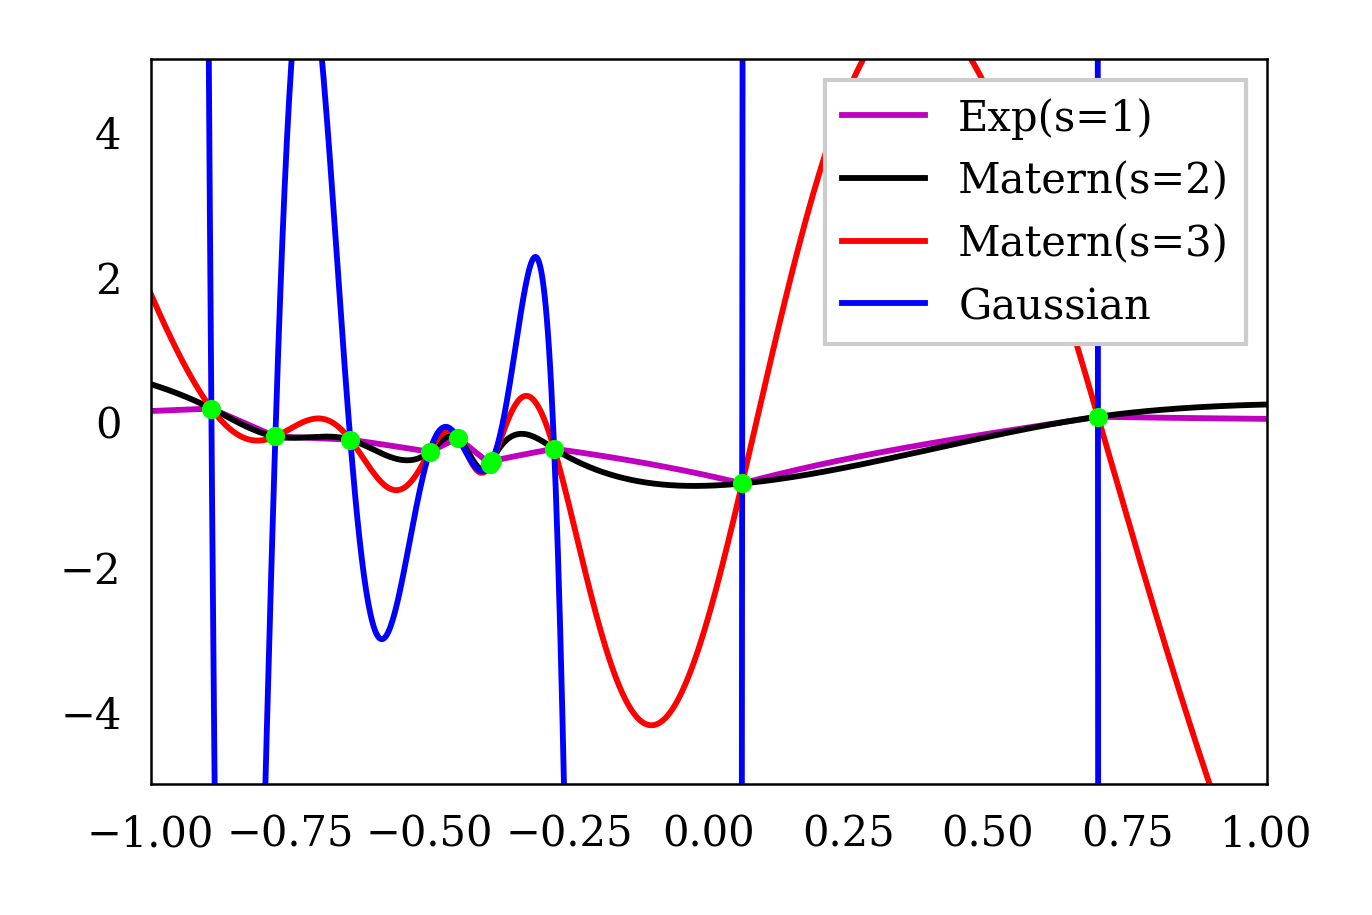

In [ ]:
np.random.seed(15)

def distmat(a,b):
    C = ((a[:,None]-b[None,:])**2)
    # C = np.sum(a**2,0)[:,None] + np.sum(b**2,0)[None,:] - 2*a.transpose().dot(b)
    return C

def solve(K, Kt, y):
    a = np.linalg.lstsq(K, y, rcond=None)[0]
    return Kt.dot(a)

n = 10
sdnoise = 0.4
x = np.random.rand(n)*2-1
y = np.abs(x)-1 + np.random.rand(n)*sdnoise
Xtest = 2*np.arange(0, 1.001, 0.001)-1

#Gaussian
alphak = 6
K = np.exp( -distmat(x, x) * alphak)
Ktest = np.exp( -distmat(Xtest, x) * alphak)
y_est1 = solve(K, Ktest, y)


#Exponential - 1
alphak = 2
temp = np.sqrt(distmat(x, x))
K = np.exp( -temp*alphak)
temp = np.sqrt(distmat(Xtest, x))
Ktest = np.exp( -temp*alphak)
y_est2 = solve(K, Ktest, y)

#Exponential - 2
alphak = 2
temp = np.sqrt(distmat(x, x))
K = (1 + temp*alphak) * np.exp(-temp*alphak)
temp = np.sqrt(distmat(Xtest, x))
Ktest = (1 + temp*alphak) * np.exp(-temp*alphak)
y_est3 = solve(K, Ktest, y)

#Exp - 3
alphak = 2
temp = distmat(x, x)
K = (1 + np.sqrt(temp)*alphak + temp*alphak**2/3) * np.exp(-np.sqrt(temp)*alphak)
temp = (distmat(Xtest, x))
Ktest = (1 + np.sqrt(temp) * alphak  +  temp * alphak**2 / 3 )* np.exp( -np.sqrt(temp) * alphak )
y_est4 = solve(K, Ktest, y)

plt.plot(Xtest, y_est2, 'm')
plt.plot(Xtest, y_est3, 'k');
plt.plot(Xtest, y_est4, 'r');
plt.plot(Xtest, y_est1, 'b')
plt.legend(['Exp(s=1)', 'Matern(s=2)', 'Matern(s=3)', 'Gaussian'], loc='upper right')

plt.plot(x, y, '.', markersize = 4, c='lime')
plt.ylim(-5,5)
plt.xlim(-1,1);

plt.savefig('fig72.svg')
files.download("fig72.svg")

#### Fig 7.3

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm

plt.figure(figsize=(10,8))


def sq_dist(a, b):
    C = ((a[:,None]-b[None,:])**2)
    return C


def affine_fit(x, y):
    a = np.polyfit(x, y, 1)
    b = a[1]
    a = a[0]
    return a, b


ns = np.round(2.0 ** np.arange(2, 10.25, 0.25)).astype(int)
nrep = 20
kernel_types = [1, 2, 4]
lambdas = 10**np.arange(2, -12, -0.25)
valtests = np.zeros((len(lambdas),len(ns),nrep,2))
kkk = 0
for kernel_type in kernel_types:
    kkk += 1
    seed = 1
    np.random.seed(seed)

    for idata in [1, 2]:
        for irep in tqdm.tqdm(range(nrep)):
            n = int(np.max(ns))
            ntest = int(np.max(ns)) * 4
            Xfull = np.random.rand(n, 1)
            Xtest = np.arange(0,ntest-1).T/(ntest-1)
            std_noise = 0.2

            if idata == 1:
                yfull = np.sin(4 * np.pi * Xfull) + std_noise * np.random.randn(n, 1)
                ytest = np.sin(4 * np.pi * Xtest)
            else:
                yfull = np.sign(np.sin(4 * np.pi * Xfull)) + std_noise * np.random.randn(n, 1)
                ytest = np.sign(np.sin(4 * np.pi * Xtest))

            for in_, n in enumerate(ns):
                X = Xfull[:n,0]
                y = yfull[:n]
                alphak = 2
                if kernel_type == 1:
                    K = np.exp(-np.sqrt(sq_dist(X,X)) * alphak)
                    Ktest = np.exp(-np.sqrt(sq_dist(Xtest,X)) * alphak)

                elif kernel_type == 2:
                    temp = np.sqrt(sq_dist(X, X))
                    K = (1 + temp * alphak) * np.exp(-temp * alphak)
                    Ktest = (1 + np.sqrt(sq_dist(Xtest, X)) * alphak) * np.exp(-np.sqrt(sq_dist(Xtest, X)) * alphak)
                elif kernel_type == 4:
                    K = np.exp(-sq_dist(X, X) * alphak * 3)
                    Ktest = np.exp(-sq_dist(Xtest, X) * alphak * 3)
                u, e = np.linalg.eig(K)
                e = np.diag(e)

                valtest = np.zeros(len(lambdas))
                for ilambda, lambda_ in enumerate(lambdas):
                    alpha = u * 1/(e + n*lambda_)* u.T * y.reshape(n,)
                    ytest_pred = Ktest * alpha
                    valtest[ilambda] = np.sum( (ytest_pred - ytest[:n])**2 )/ntest
                valtests[:,in_,irep,idata-1] = valtest

##########
    print("Second loop")
    for idata in [1,2]:

        plt.subplot(3, 3, (kkk-1)*3 + idata)
        n = 128

        X = np.random.rand(n)
        Xtest = np.linspace(0, 1, ntest)
        std_noise = 0.2
        if idata == 1:
            y = np.sin(4 * np.pi * X) + std_noise * np.random.randn(n)
            ytest = np.sin(4 * np.pi * Xtest)
        elif idata == 2:
            y = np.sign(np.sin(4 * np.pi * X)) + std_noise * np.random.randn(n)
            ytest = np.sign(np.sin(4 * np.pi * Xtest))

        alphak = 2
        if kernel_type == 1:
            K = np.exp(-np.sqrt(sq_dist(X,X)) * alphak)
            Ktest = np.exp(-np.sqrt(sq_dist(Xtest,X)) * alphak)
        elif kernel_type == 2:
            temp = np.sqrt(sq_dist(X, X))
            K = (1 + temp * alphak) * np.exp(-temp * alphak)
            Ktest = (1 + np.sqrt(sq_dist(Xtest, X)) * alphak) * np.exp(-np.sqrt(sq_dist(Xtest, X)) * alphak)
        elif kernel_type == 3:
            temp = np.sqrt(sq_dist(X, X))
            K = (1 + np.sqrt(sq_dist(X, X)) * alphak + sq_dist(X, X) * alphak**2 / 3) * np.exp(-np.sqrt(sq_dist(X, X)) * alphak)
            Ktest = (1 + np.sqrt(sq_dist(Xtest, X)) * alphak + sq_dist(Xtest, X) * alphak**2 / 3) * np.exp(-np.sqrt(sq_dist(Xtest, X)) * alphak)
        elif kernel_type == 4:
            K = np.exp(-sq_dist(X, X) * alphak * 3)
            Ktest = np.exp(-sq_dist(Xtest, X) * alphak * 3)


        u, e = np.linalg.eig(K)
        e = np.diag(e)

        lambdas = 10 ** np.arange(2, -12, -0.25)

        valtest = np.zeros(len(lambdas))
        for ilambda in range(len(lambdas)):
            lambda_ = lambdas[ilambda]

            alpha = u * 1/(e + n*lambda_)* np.dot(u.T, y)
            ytest_pred = Ktest @ alpha
            valtest[ilambda] = 1 / ntest * np.sum((ytest_pred - ytest) ** 2)

        ilambda = np.argmin(valtest)
        lambda_ = lambdas[ilambda]

        alpha = u * 1/(e + n*lambda_)* np.dot(u.T, y)
        ytest_pred = Ktest @ alpha

        plt.plot(Xtest, ytest, 'r', linewidth=2)
        plt.plot(Xtest, ytest_pred, 'k', linewidth=2)
        plt.plot(X, y, 'kx')
        plt.legend(['target', 'prediction'])
        plt.xlabel('x')
        plt.ylabel('y')
        plt.axis([0, 1, -1.5, 2])

        if idata == 1:
            plt.title('Smooth target')
        elif idata == 2:
            plt.title('Non-smooth target')


    plt.subplot(3, 3, (kkk - 1) * 3 + 3)
    plt.plot(np.log2(ns), np.log2(np.min(np.mean(valtests[:, :, :, 0], axis=2),axis=0)), 'b', linewidth=2)
    plt.plot(np.log2(ns), np.log2(np.min(np.mean(valtests[:, :, :, 1], axis=2),axis=0)), 'r', linewidth=2)

    a, b = affine_fit(np.log2(ns), np.log2(np.min(np.mean(valtests[:, :, :, 0], axis=2),axis=0)))
    plt.plot(np.log2(ns), a * np.log2(ns) + b, 'b:', linewidth=2)

    a, b = affine_fit(np.log2(ns), np.log2(np.min(np.mean(valtests[:, :, :, 1], axis=2),axis=0)))
    plt.plot(np.log2(ns), a * np.log2(ns) + b, 'r:', linewidth=2)

    plt.xlabel('log_2(n)')
    plt.ylabel('log_2(excess risk)')
    plt.legend(['smooth target', 'non-smooth target'], loc='lower left')
    plt.title('Convergence rates', fontweight='normal')
    plt.ylim([-11, 0.5])
    plt.xlim([2, 10])
plt.tight_layout(pad=2.0)
plt.show()


 60%|██████    | 12/20 [03:08<02:05, 15.70s/it]


KeyboardInterrupt: ignored

<Figure size 6000x4800 with 0 Axes>